In [1]:
import pandas as pd
import numpy as np
import sqlite3
import os
from datetime import datetime


In [3]:
# Load data
conn = sqlite3.connect("../fraud.db")
df = pd.read_sql("SELECT * FROM transactions", conn)
conn.close()

In [5]:
# Convert datetime
df["transactionDateTime"] = pd.to_datetime(df["transactionDateTime"])
df["hour"] = df["transactionDateTime"].dt.hour
df["dayofweek"] = df["transactionDateTime"].dt.day_name()

In [7]:
# Log amount
df["log_amount"] = np.log1p(df["transactionAmount"])

In [ ]:
# High value flag
high_value_thresh = df["transactionAmount"].quantile(0.95)
df["is_high_value"] = (df["transactionAmount"] > high_value_thresh).astype(int)

# Nighttime flag
df["is_day"] = df["hour"].isin(range(11, 14)).astype(int)

In [11]:
df[["transactionAmount", "log_amount", "hour", "dayofweek", "is_high_value", "is_night"]].head()

,transactionAmount,log_amount,hour,dayofweek,is_high_value,is_night
0,98.55,4.600660,14,Saturday,0,0
1,74.51,4.324265,5,Tuesday,0,1
2,7.47,2.136531,9,Tuesday,0,0
3,7.47,2.136531,2,Saturday,0,1
4,71.18,4.279163,21,Thursday,0,0


In [12]:
# CVV mismatch (cardCVV != enteredCVV)
df["cvv_mismatch"] = (df["cardCVV"] != df["enteredCVV"]).astype(int)

# Country mismatch (acqCountry != merchantCountryCode)
df["country_mismatch"] = (df["acqCountry"] != df["merchantCountryCode"]).astype(int)

# Card not present
df["card_not_present"] = (df["cardPresent"] == 0).astype(int)

# Show results
df[["cardCVV", "enteredCVV", "cvv_mismatch", "acqCountry", "merchantCountryCode", "country_mismatch", "cardPresent", "card_not_present"]].head()


,cardCVV,enteredCVV,cvv_mismatch,acqCountry,merchantCountryCode,country_mismatch,cardPresent,card_not_present
0,414,414,0,US,US,0,0,1
1,486,486,0,US,US,0,1,0
2,486,486,0,US,US,0,0,1
3,486,486,0,US,US,0,0,1
4,885,885,0,US,US,0,1,0


In [13]:
# High-risk categories from EDA
high_risk_categories = ["airline", "online_retail", "rideshare", "online_gifts"]

# Binary high-risk flag
df["high_risk_category"] = df["merchantCategoryCode"].isin(high_risk_categories).astype(int)

# Ordinal risk mapping
category_risk_map = {
    "airline": "high",
    "online_retail": "high",
    "rideshare": "high",
    "online_gifts": "high",
    "furniture": "medium",
    "auto": "medium",
    "entertainment": "medium",
    "fastfood": "low",
    "food": "low",
    "subscriptions": "low"
}

df["category_risk_level"] = df["merchantCategoryCode"].map(category_risk_map).fillna("low")

# Preview
df[["merchantCategoryCode", "high_risk_category", "category_risk_level"]].head()


,merchantCategoryCode,high_risk_category,category_risk_level
0,rideshare,1,high
1,entertainment,0,medium
2,mobileapps,0,low
3,mobileapps,0,low
4,fastfood,0,low


In [ ]:
df.to_csv("data/processed_transactions.csv", index=False)

import sqlite3
conn = sqlite3.connect("fraud.db")
df.to_sql("processed_transactions", conn, if_exists="replace", index=False)
conn.close()


In [15]:
# Save as CSV in the data folder
df.to_csv("../data/processed_transactions.csv", index=False)

In [17]:
conn = sqlite3.connect("../fraud.db")
df.to_sql("processed_transactions", conn, if_exists="replace", index=False)
conn.close()

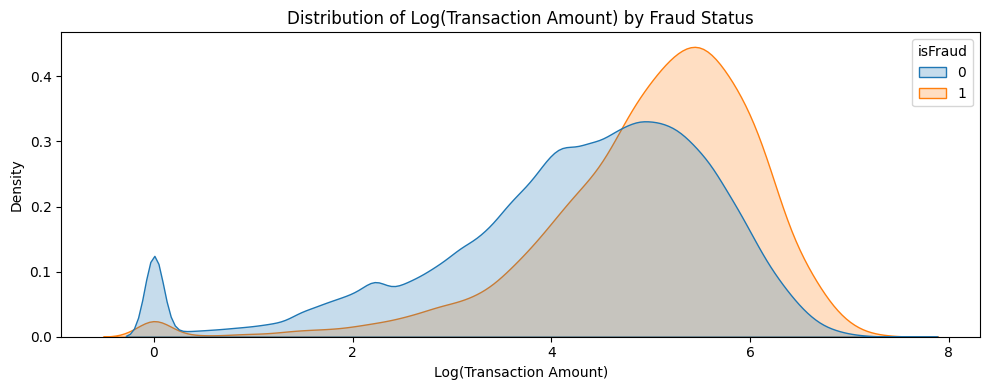

In [18]:
# Compare log_amount by fraud status
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.kdeplot(data=df, x="log_amount", hue="isFraud", common_norm=False, fill=True)
plt.title("Distribution of Log(Transaction Amount) by Fraud Status")
plt.xlabel("Log(Transaction Amount)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()



C:\Users\isaac\AppData\Local\Temp\ipykernel_31348\3608469160.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="is_high_value", y="isFraud", data=high_value_rate, palette= "prism")


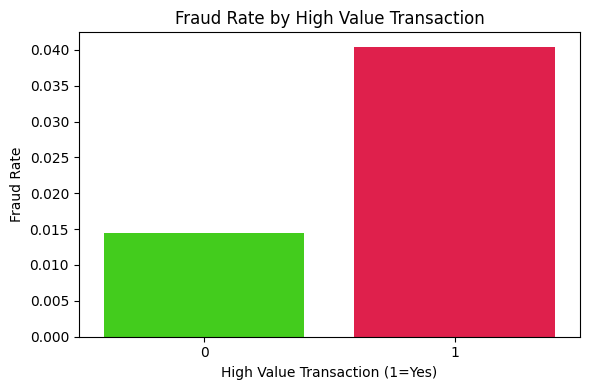

In [60]:
high_value_rate = df.groupby("is_high_value")["isFraud"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="is_high_value", y="isFraud", data=high_value_rate, palette= "prism")
plt.title("Fraud Rate by High Value Transaction")
plt.xlabel("High Value Transaction (1=Yes)")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()


C:\Users\isaac\AppData\Local\Temp\ipykernel_31348\3706784205.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="is_night", y="isFraud", data=night_rate, palette= "prism")


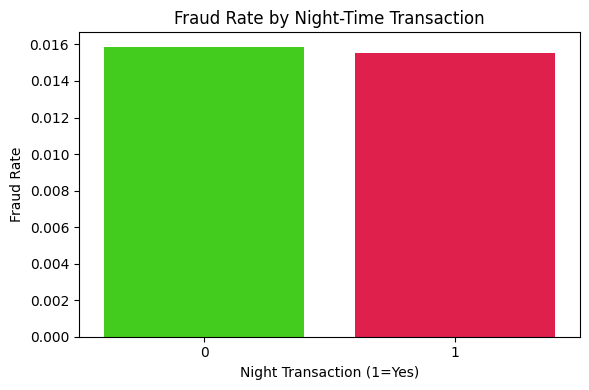

In [61]:
night_rate = df.groupby("is_night")["isFraud"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="is_night", y="isFraud", data=night_rate, palette= "prism")
plt.title("Fraud Rate by Day-Time Transaction")
plt.xlabel("Night Transaction (1=Yes)")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()


C:\Users\isaac\AppData\Local\Temp\ipykernel_31348\2303972180.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="cvv_mismatch", y="isFraud", data=cvv_rate, palette= "prism")


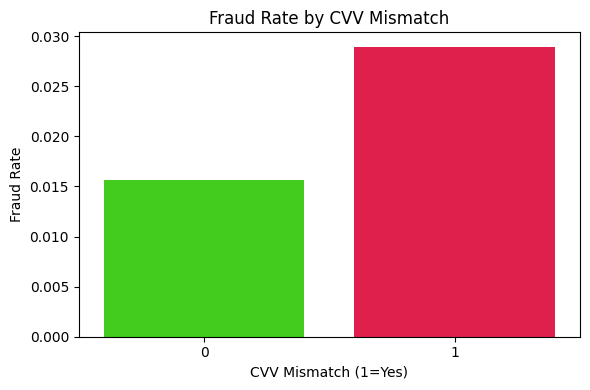

In [62]:
cvv_rate = df.groupby("cvv_mismatch")["isFraud"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="cvv_mismatch", y="isFraud", data=cvv_rate, palette= "prism")
plt.title("Fraud Rate by CVV Mismatch")
plt.xlabel("CVV Mismatch (1=Yes)")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()


C:\Users\isaac\AppData\Local\Temp\ipykernel_31348\2044379972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country_mismatch", y="isFraud", data=country_rate, palette= "prism")


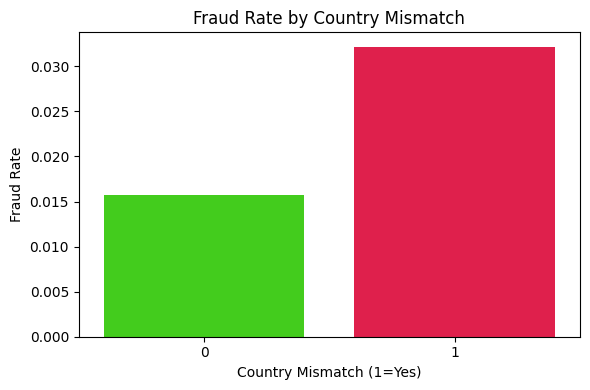

In [63]:
country_rate = df.groupby("country_mismatch")["isFraud"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="country_mismatch", y="isFraud", data=country_rate, palette= "prism")
plt.title("Fraud Rate by Country Mismatch")
plt.xlabel("Country Mismatch (1=Yes)")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()


C:\Users\isaac\AppData\Local\Temp\ipykernel_31348\993028881.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="card_not_present", y="isFraud", data=card_present_rate, palette= "prism")


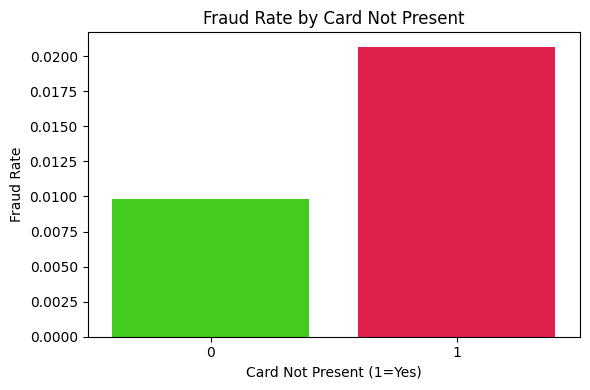

In [64]:
card_present_rate = df.groupby("card_not_present")["isFraud"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="card_not_present", y="isFraud", data=card_present_rate, palette= "prism")
plt.title("Fraud Rate by Card Not Present")
plt.xlabel("Card Not Present (1=Yes)")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()


C:\Users\isaac\AppData\Local\Temp\ipykernel_31348\2634944034.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category_risk_level", y="isFraud", data=category_risk_rate,


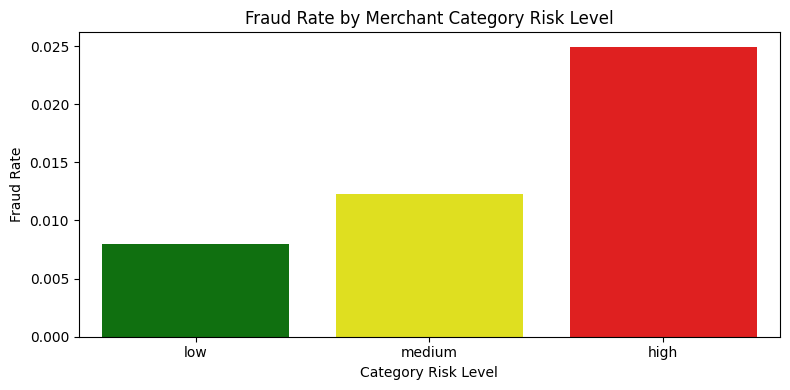

In [72]:
category_risk_rate = df.groupby("category_risk_level")["isFraud"].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x="category_risk_level", y="isFraud", data=category_risk_rate,
            order=["low", "medium", "high"], palette=["green", "yellow", "red"])
plt.title("Fraud Rate by Merchant Category Risk Level")
plt.xlabel("Category Risk Level")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()


In [73]:
features_to_corr = [
    "log_amount",
    "is_high_value",
    "is_night",
    "cvv_mismatch",
    "country_mismatch",
    "card_not_present",
    "high_risk_category",  # if you added it
    "isFraud"
]


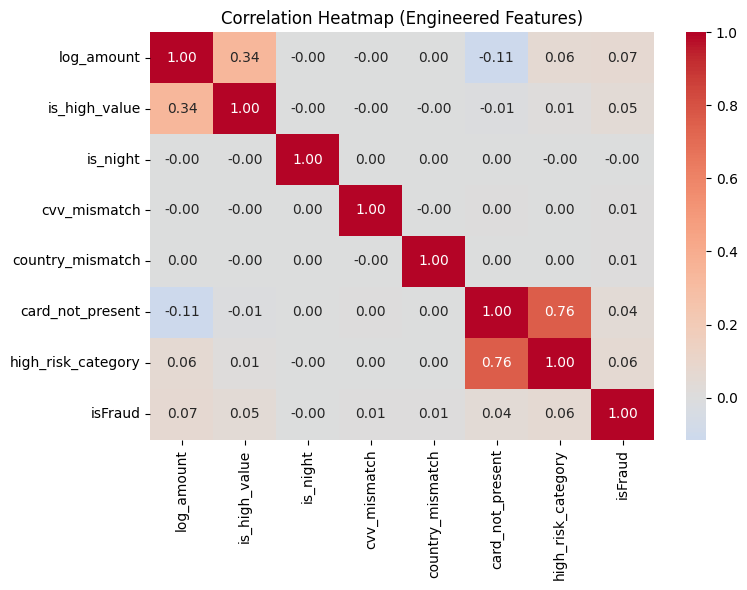

In [75]:
# Compute correlations
corr = df[features_to_corr].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (Engineered Features)")
plt.tight_layout()
plt.savefig("../images/img18.png")
plt.show()